In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./STUFF/colors.css", "r").read()
    return HTML(styles)
css_styling()

# CH160: Introduction to Python (Vol III)

<img src="./STUFF/vol_3.jpg" width="600">

In this session, we are going to introduce **functions** - chunks of code that we can write, store somewhere, and use as we please in order to keep our coding cleaner and making in better. In order to do this, we are going to use the same molecular dynamics data we have dealt with in the last session. We'll start with a function to plot a heat map, and then we'll move onto calculating definite integrals via a Monta Carlo approach

In [3]:
# Always a good thing to import everything we need in one of the first cells
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

## Clean up the plotting 
Very often we find ourselves copy/pasting entire blocks of code - for instance, everytime we plot something. For instance...

In [6]:
# Get the data...
data = np.loadtxt('./STUFF/md_data.dat',skiprows=1)
data_df = pd.DataFrame(data)
data_df = data_df.iloc[10:]

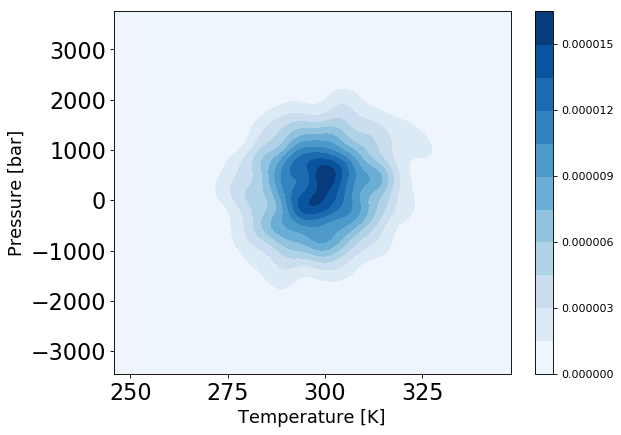

In [8]:
# Plot the Temperature/Pressure heat map
plt.figure(figsize=(8,6), dpi= 80, facecolor='w', edgecolor='k') 
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
sns.kdeplot(data_df.iloc[:,2], data_df.iloc[:,3], shade=True, cmap="Blues", cbar=True)
plt.xlabel('Temperature [K]', fontsize=16)
plt.ylabel('Pressure [bar]', fontsize=16)
plt.show()

### A function to plot a heatmap

In [14]:
def plt_hmap(x_data,y_data,x_label,y_label):
    plt.figure(figsize=(8,6), dpi= 80, facecolor='w', edgecolor='k') 
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    sns.kdeplot(x_data,y_data, shade=True, cmap="Blues", cbar=True)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.show()

Let's have a look at the syntax: we start with the ```def``` command, followed by the name we want to assign to our function, in this case ```plt_hmap```. Then, in brackets, we specify the arguments that this function wants: ```x_data,y_data,x_label``` and ```y_label```. Finally, we end with a `:`. Note that, much as a ```for``` loop, everything that we want to include in our function has to be intended.

Great - now, time to use our function! We call it simply by specifying its name, ```plt_hmap``` in this case, followed by the values of the arguments: for each argument we need, we have to provide a proper input. For instance, the ```x_data``` argument wants the data to plot/bin along the x axis - ```data_df.iloc[:,2]```, which select the third column of our dataset, is a perfectly valid choice.

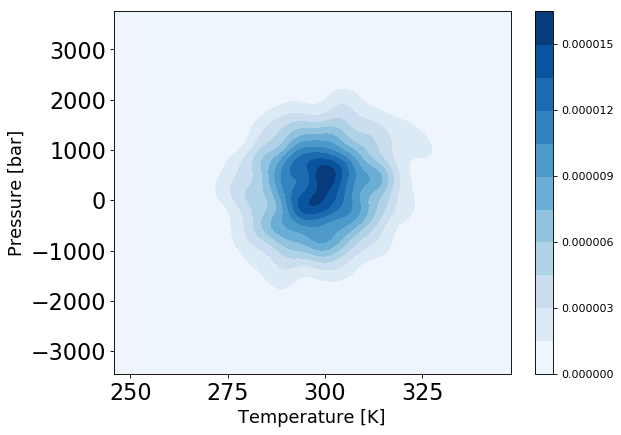

In [16]:
# def plt_hmap(x_data,y_data,x_label,y_label):
plt_hmap(data_df.iloc[:,2],data_df.iloc[:,3],'Temperature [K]', 'Pressure [bar]')

One line only!

<div class=warn>

<h2> A function to plot a probability density function </h2>

Write down a function to plot a probability density function. Test it with the pressure data.

In [19]:
def plot_pdf(x_data,n_bins,x_label):
    
    x_data = np.array(x_data)
    
    smallest = np.amin(x_data)
    largest = np.amax(x_data)

    r_range = largest - smallest
    bin_size = r_range/n_bins

    histogram = np.zeros((n_bins,2))

    for i in range (0, n_bins): 
        lower_bound = smallest+(i*bin_size)
        upper_bound = lower_bound + bin_size
        histogram[i,0] = lower_bound + (bin_size/2)
        for j in range (0, len(x_data)): 
            if x_data[j] >= lower_bound and x_data[j] < upper_bound :
                histogram[i,1] = histogram[i,1] +1

    area = 0.0
    pdf = np.zeros((n_bins,2))
    pdf[:,0] = histogram[:,0]

    for i in range (0, n_bins): 
        area = area + (bin_size*histogram[i,1])

    for i in range (0, n_bins): 
        pdf[i,1] = histogram[i,1] / area

    plt.xlabel(x_label,fontsize=16)
    plt.ylabel('PDF',fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)

    axes = plt.gca()
    plt.bar(pdf[:,0],pdf[:,1],width=bin_size)
    plt.show()

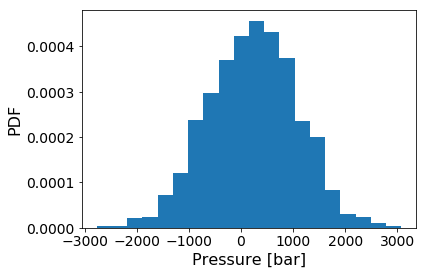

In [20]:
x_data = data_df.iloc[:,3]
plot_pdf(x_data,20,'Pressure [bar]')

## Monte Carlo Integration

Calculating definite integrals analytically can be an absolute pain. In many cases, in fact, it is not even possible - hence, we have to calculate an estimate of our integral *numerically*. As you hopefully remember, the definite integral from of a given function $f(x)$ from a to b, $\int_a^b f(x) dx$, corresponds to the area under the curve defined by $f(x)$:

<img src="./STUFF/mc.png" width="600">

One way to get an idea (a very accurate estimate, in fact...) of this area we are after is to use a numerical approach known as Monte Carlo integration.

<img src="./STUFF/casino.png" width="600">

Let's say we are interested in claculating the definite integral (from -1 to 1 ) of the normal distribution:

$$
\int_{-1}^{1} \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}} dx
$$

This integral is actually [quite tricky to solve analytically](https://en.wikipedia.org/wiki/Gaussian_integral).

We start by isolating the area of the function we need to consider, that is from a to b.

In [21]:
# We know functions, now!
def norm_distr(x):
    return((1/np.sqrt(2*np.pi))*np.exp(-(x**2)/2))

In [23]:
x_start = -1
x_finish = 1
n_p = 1000
# Fills a vector with n_p equally spaced points from x_start to x_finish.
# Very useful to evaluate functions along specific intervals
X=np.linspace(x_start,x_finish,n_p)
#print(X)

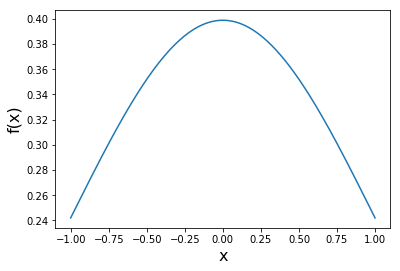

In [24]:
# Let's have a quick look...
plt.plot(X,norm_distr(X))
plt.xlabel('x', fontsize=16)
plt.ylabel('f(x)', fontsize=16)
plt.show()

Excellent. Now, we can easily calculate the area of this graph: imagine that your graph is a dartboard. What we want to do is to shoot darts at it: counting how many darts fall above and below the curve gives you an indication of the portion of the graph which corresponds to the area under the curve. Here's how it's done...

In [25]:
def integrate(x1,x2,func,n):
    X=np.linspace(x1,x2,1000)
    y1=0
    y2=max((func(X)))+0.25
    
    # This is the area of the graph
    area=(x2-x1)*(y2-y1)
    
    check=[]
    xs=[]
    ys=[]
    
    # Here we shoot our darts!
    for i in range(n):
        x=np.random.uniform(x1,x2,1)
        xs.append(x)
        y=np.random.uniform(y1,y2,1)
        ys.append(y)
        
        # Here we decide whether our darts lie above or below the curve...
        if abs(y)>abs(func(x)) or y<0:
            check.append(0)
        else:
            check.append(1)
            
    return(np.mean(check)*area,xs,ys,check)

0.7657516550263452


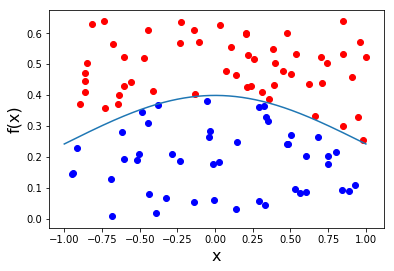

In [27]:
# Number of darts we are going to shoot
n_mc = 100

# We print the first argument returned by the function via the [0] additional keyword
# That's the value of our integral!
print(integrate(x_start,x_finish,norm_distr,n_mc)[0])

# We store our results into a panda dataframe, as I want to visualize where the darts ended up being...
_,x,y,c=integrate(x_start,x_finish,norm_distr,n_mc)
df=pd.DataFrame()
df['x']=x
df['y']=y
df['c']=c

# Quick look...
plt.plot(X,norm_distr(X))
plt.scatter(df[df['c']==0]['x'],df[df['c']==0]['y'],color='red')
plt.scatter(df[df['c']==1]['x'],df[df['c']==1]['y'],color='blue')
plt.xlabel('x', fontsize=16)
plt.ylabel('f(x)', fontsize=16)
plt.show()

A very accurate result for this integral (from [here](https://www.wolframalpha.com/input/?i=%5Cint_%7B-1%7D%5E%7B1%7D+%5Cfrac%7B1%7D%7B%5Csqrt%7B2%5Cpi%7D%7D+%5Cexp%28-%28x%5E2%29%2F2%29dx) - fun place!) is 0.682689. By throwing just 100 darts we got quite close already!

<div class=warn>

<h2> More darts! </h2>

Plot the result of our Monte Carlo integration above as a function of the number of darts (note: insanely large numbers will take ages, test this step by step!)

<div class=warn>

<h2> A more challenging case... </h2>

The values of the standard distribution we have considered above are always positives. What if we want to get an estimate of the area under a curve that spans both positive and negative values? Say:

$$
\int_{-2}^{2} x^5 - 6 x^2 dx
$$

Hint: we have to treat the problem differentl according to whether or not the section of the curve we are dealing with is below or above the x axis!